### Импорт библиотек и загрузка данных

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt

from scipy.stats import boxcox

In [43]:
female_births = pd.read_csv("https://raw.githubusercontent.com/MelnikDM/Netology/main/Time_Series/data/daily-total-female-births-in-cal.csv")['Count']
airline_passengers = pd.read_csv("https://raw.githubusercontent.com/MelnikDM/Netology/main/Time_Series/data/international-airline-passengers.csv")['Count']
mean_monthly_temp = pd.read_csv("https://raw.githubusercontent.com/MelnikDM/Netology/main/Time_Series/data/mean-monthly-air-temperature-deg.csv")["Deg"]
boston_rob = pd.read_csv("https://raw.githubusercontent.com/MelnikDM/Netology/main/Time_Series/data/monthly-boston-armed-robberies-j.csv")['Count']
sales_of_company_x = pd.read_csv("https://raw.githubusercontent.com/MelnikDM/Netology/main/Time_Series/data/monthly-sales-of-company-x-jan-6.csv")['Count']
dowjones_closings = pd.read_csv("https://raw.githubusercontent.com/MelnikDM/Netology/main/Time_Series/data/weekly-closings-of-the-dowjones-.csv")["Close"]

### Определение основных функций

Временные ряды являются стационарными, если они не имеют тенденций или сезонных эффектов. Статистически это означает, что временной ряд имеет одинаковые меры разброса. Наблюдения из нестационарного временного ряда показывают сезонные эффекты и тренды, которые зависят от времени. Нестационарный временной ряд, в отличие от стационарного, тяжело анализировать и моделировать.

Для проверки на стационарность используется ряд тестов. В данном случае мы будем использовать тест ADF (расширенный тест Дики-Фуллера). Интуиция данного теста заключается в том, что он определяет, насколько сильно временной ряд определяется трендом.

- **Нулевая гипотеза (H0):** временной ряд нестационарный.
- **Альтернативная гипотеза (H1)**: временной ряд является стационарным.

Уровень значимости возьмем p = 0.05. Если полученное значение будет выше 0.05, то нулевая гипотеза не может быть отвергнута. И наоборот.

In [44]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    X = timeseries.values
    result = adfuller(X, autolag='AIC')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Lags Used: %f' % result[2])
    print('Number of Observations Used: %f' % result[3])
    print('Critical Values:')
    for key, value in result[4].items():
      print('\t%s: %.3f' % (key, value))

Также нам необходимо задать функцию вывода коррелограмм - графиков автокорреляции. Автокорреляция - это поиск корреляций между значениями временного ряда и значениями этого же ряда со сдвигом. 

Дополнительно мы построим график частичной автокорреляции - сводки взаимосвязи между наблюдением во временном ряду с наблюдениями на предыдущих временных этапах с удалением взаимосвязей между промежуточными наблюдениями.

In [45]:
def tsplot(y, lags=None, figsize=(12, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

### daily-total-female-births-in-cal

Results of Dickey-Fuller Test:
ADF Statistic: -4.808291
p-value: 0.000052
Lags Used: 6.000000
Number of Observations Used: 358.000000
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571


/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


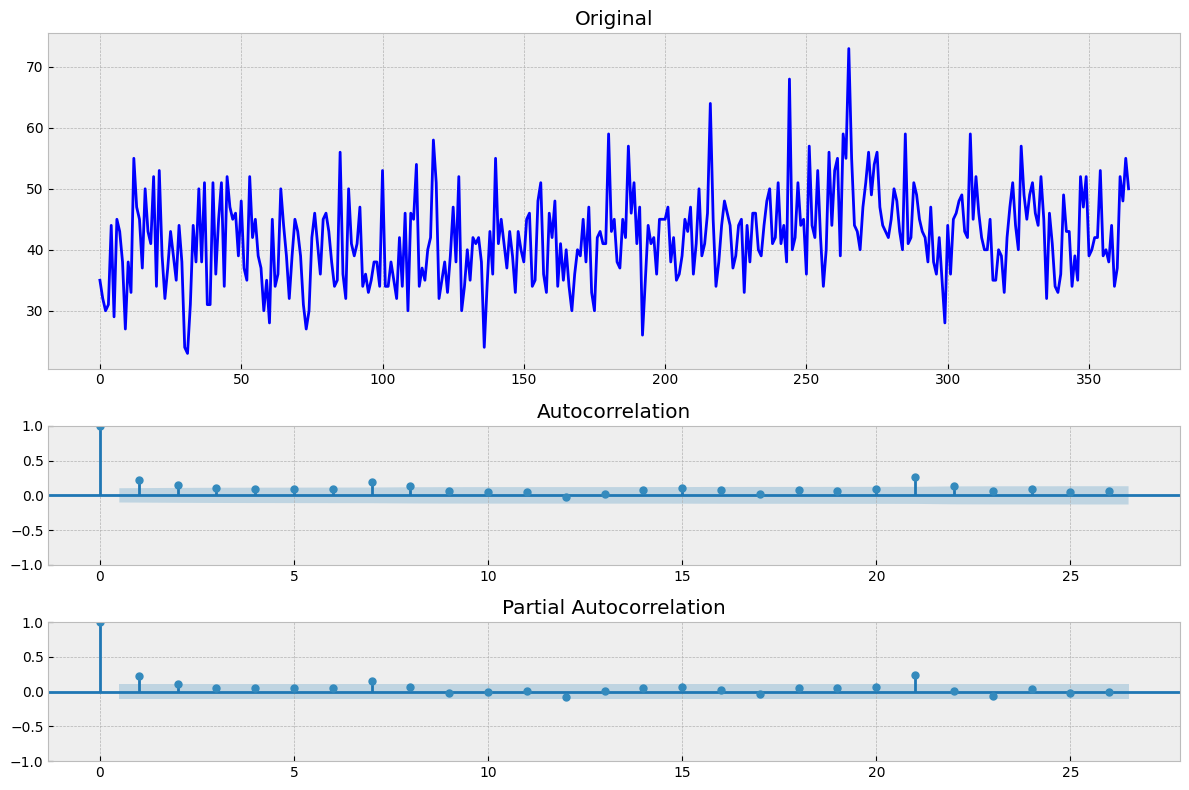

In [46]:
tsplot(female_births)

Мы видим, что p-value близко к нулю, тренды и сезонность не прослеживаются, т.е. ряд стационарный.

### international-airline-passengers

Results of Dickey-Fuller Test:
ADF Statistic: 0.815369
p-value: 0.991880
Lags Used: 13.000000
Number of Observations Used: 130.000000
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579


/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


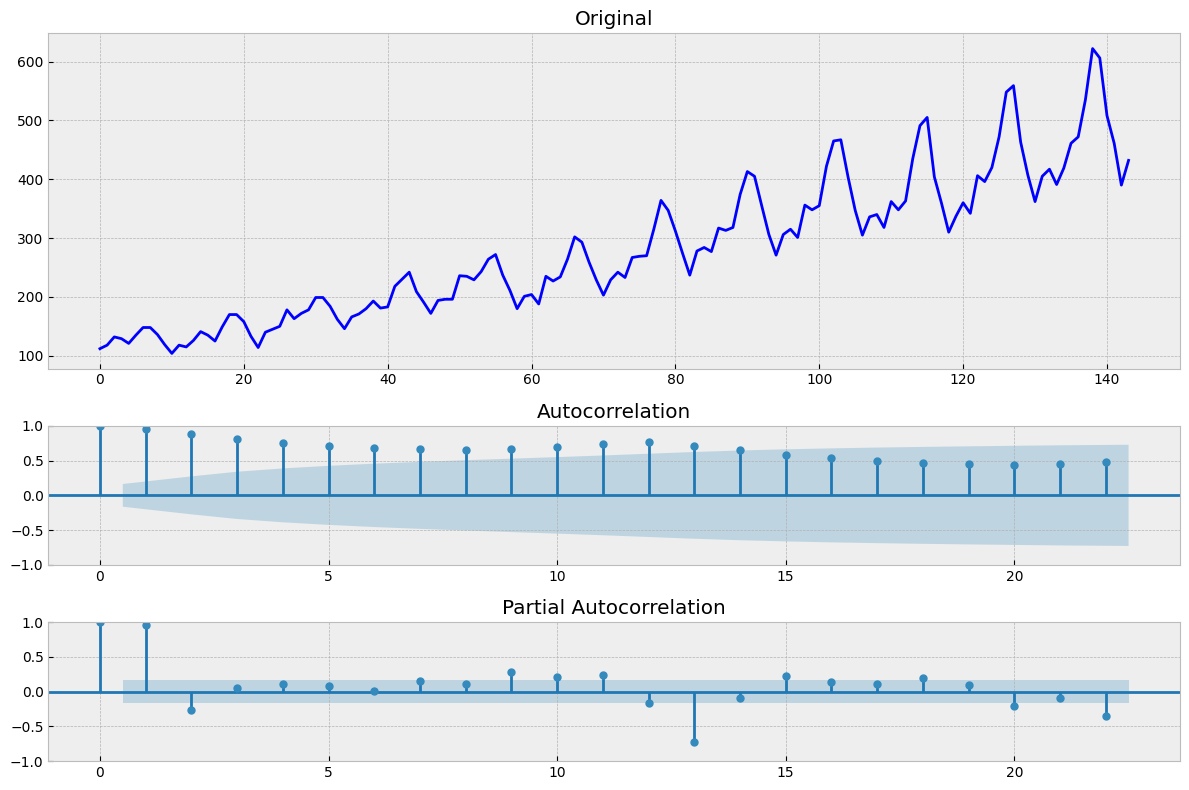

In [47]:
tsplot(airline_passengers)

Мы видим, что p-value больше установленного уровня значимости, а, следовательно, присутствуют тренд и сезонность, т.е. ряд нестационарен. Попробуем применить преобразование Бокса-Кокса.

**Преобразование Бокса-Кокса** — это метод преобразования ненормально распределенного набора данных в более нормально распределенный. Основная идея этого метода состоит в том, чтобы найти некоторое значение λ,чтобы преобразованные данные были как можно ближе к нормальному распределению.

In [48]:
airline_passengers_bc = boxcox(airline_passengers, 0)
airline_passengers_bc = pd.Series(airline_passengers_bc)
test_stationarity(airline_passengers_bc)

Results of Dickey-Fuller Test:
ADF Statistic: -1.717017
p-value: 0.422367
Lags Used: 13.000000
Number of Observations Used: 130.000000
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579


Преобразование не сработало. 

 Судя по графикам, у нас наблюдается явная сезонность с окном в 12 месяцев. Попробуем это проверить, построив график сезонности.

<Axes: xlabel='Month'>

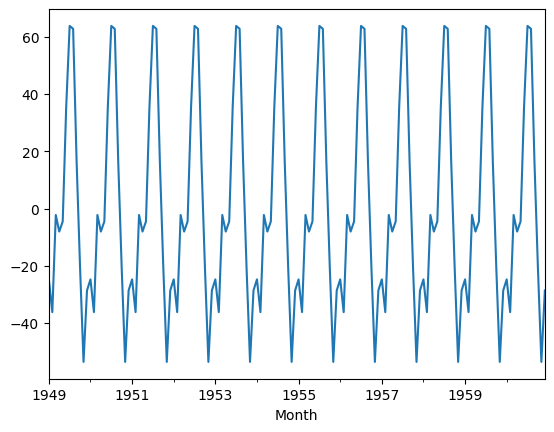

In [49]:
from statsmodels.tsa.seasonal import seasonal_decompose

airline_passengers_d = pd.read_csv("https://raw.githubusercontent.com/MelnikDM/Netology/main/Time_Series/data/international-airline-passengers.csv", index_col=0, parse_dates=True)

decompose_data = seasonal_decompose(airline_passengers_d, model="additive")
seasonality = decompose_data.seasonal
seasonality.plot() 

На графике сезонности мы можем видеть структуру сезонности для каждого года, которая является циклической и многократно повторяется. 

Используем окно в 12 месяцев и продифференцируем наши данные.

Results of Dickey-Fuller Test:
ADF Statistic: -3.383021
p-value: 0.011551
Lags Used: 1.000000
Number of Observations Used: 130.000000
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579


/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


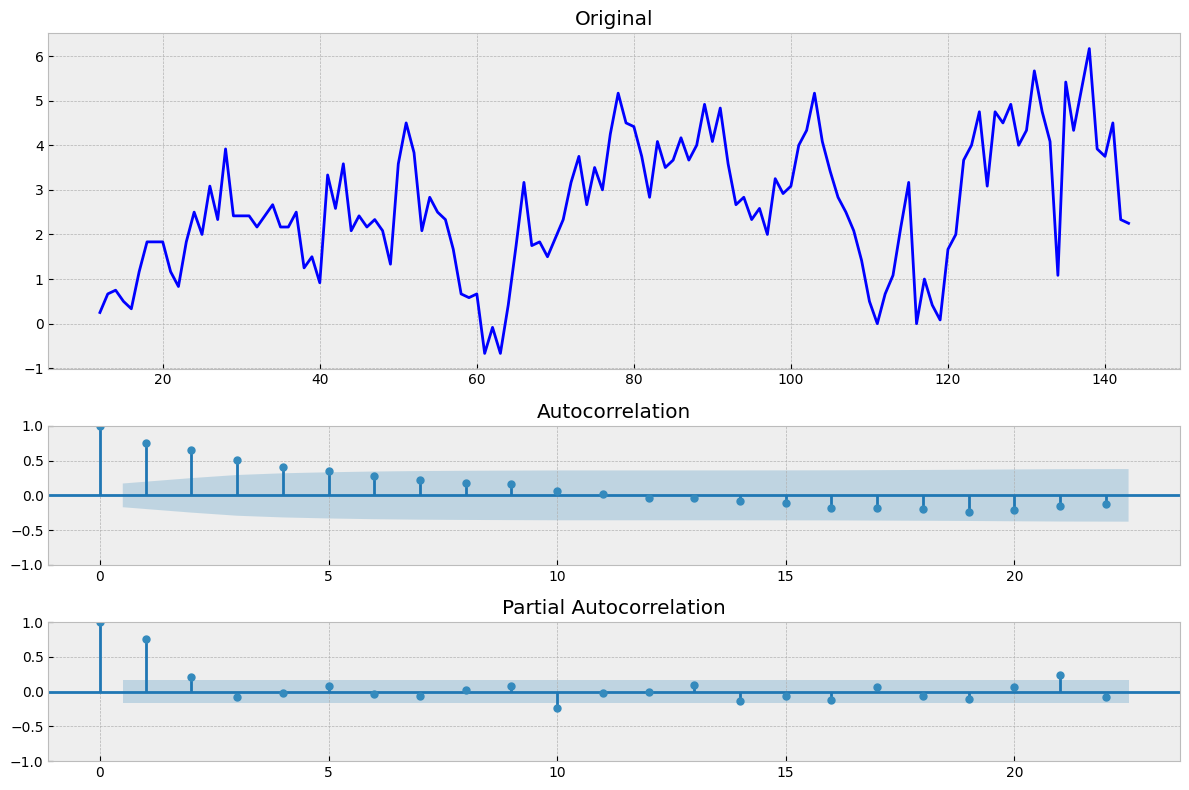

In [50]:
 rolling_mean = airline_passengers.rolling(window = 12).mean()
 rolling_mean_diff = rolling_mean - rolling_mean.shift()

 tsplot(rolling_mean_diff.dropna())

Теперь значение p-value стало меньше порогового. Данные стационарны.

### mean-monthly-air-temperature-deg

Results of Dickey-Fuller Test:
ADF Statistic: -3.255492
p-value: 0.016989
Lags Used: 14.000000
Number of Observations Used: 225.000000
Critical Values:
	1%: -3.460
	5%: -2.874
	10%: -2.574


/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


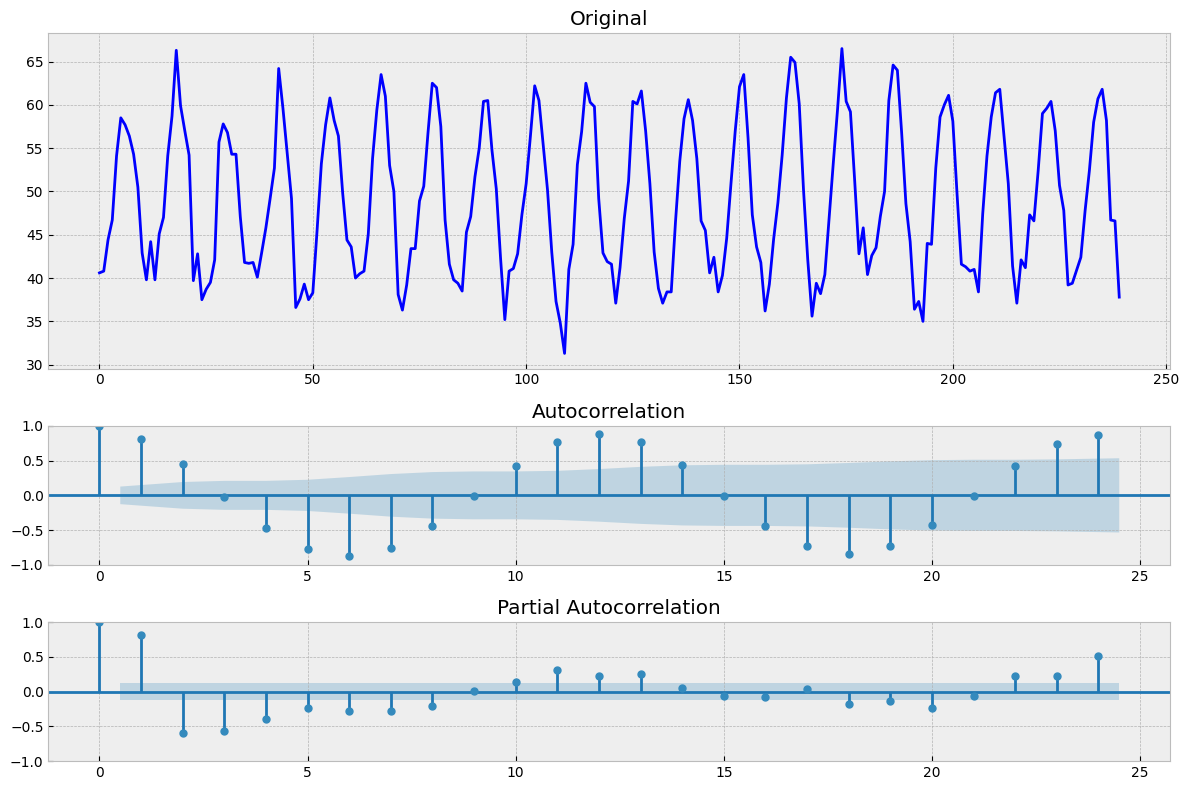

In [51]:
tsplot(mean_monthly_temp)

p-value меньше порогового значения, но есть сезонность. Уберем ее.

Results of Dickey-Fuller Test:
ADF Statistic: -6.072501
p-value: 0.000000
Lags Used: 12.000000
Number of Observations Used: 215.000000
Critical Values:
	1%: -3.461
	5%: -2.875
	10%: -2.574


/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


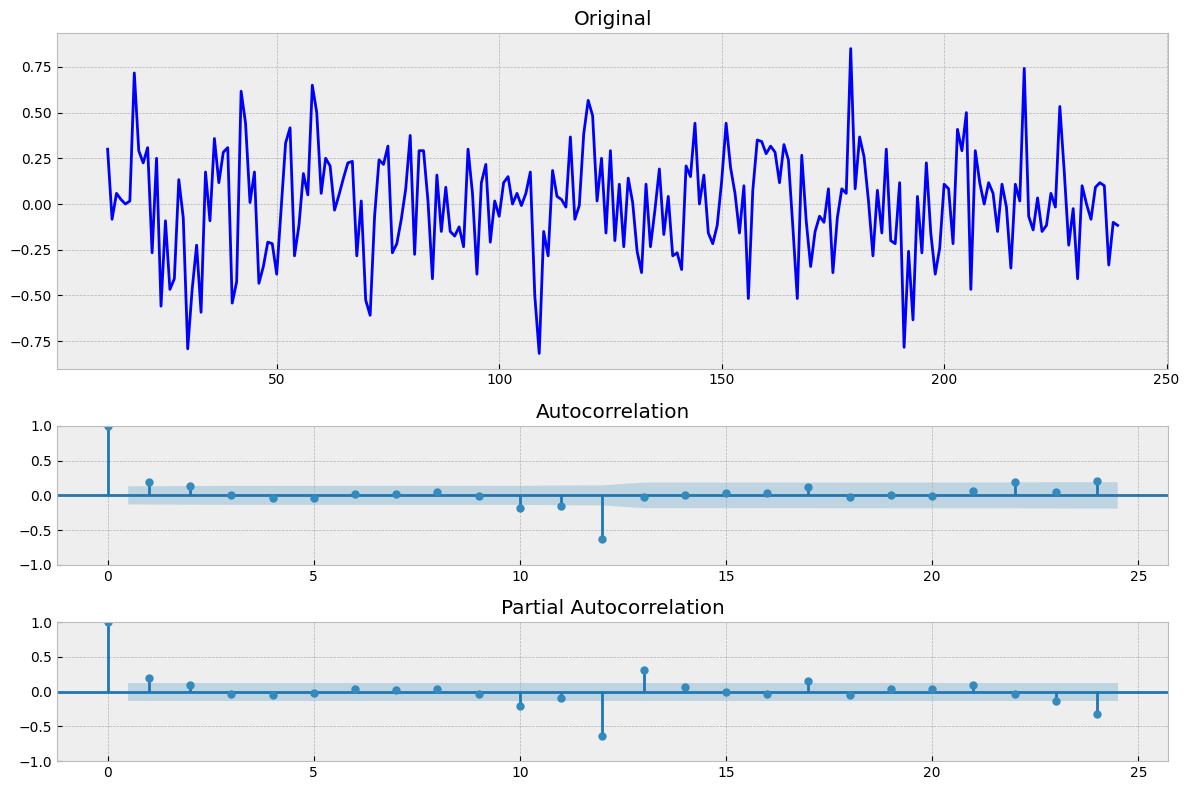

In [52]:
rolling_mean_temp = mean_monthly_temp.rolling(window = 12).mean()
rolling_mean_diff_temp = rolling_mean_temp - rolling_mean_temp.shift()

tsplot(rolling_mean_diff_temp.dropna())

### monthly-boston-armed-robberies-j

Results of Dickey-Fuller Test:
ADF Statistic: 1.001102
p-value: 0.994278
Lags Used: 11.000000
Number of Observations Used: 106.000000
Critical Values:
	1%: -3.494
	5%: -2.889
	10%: -2.582


/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


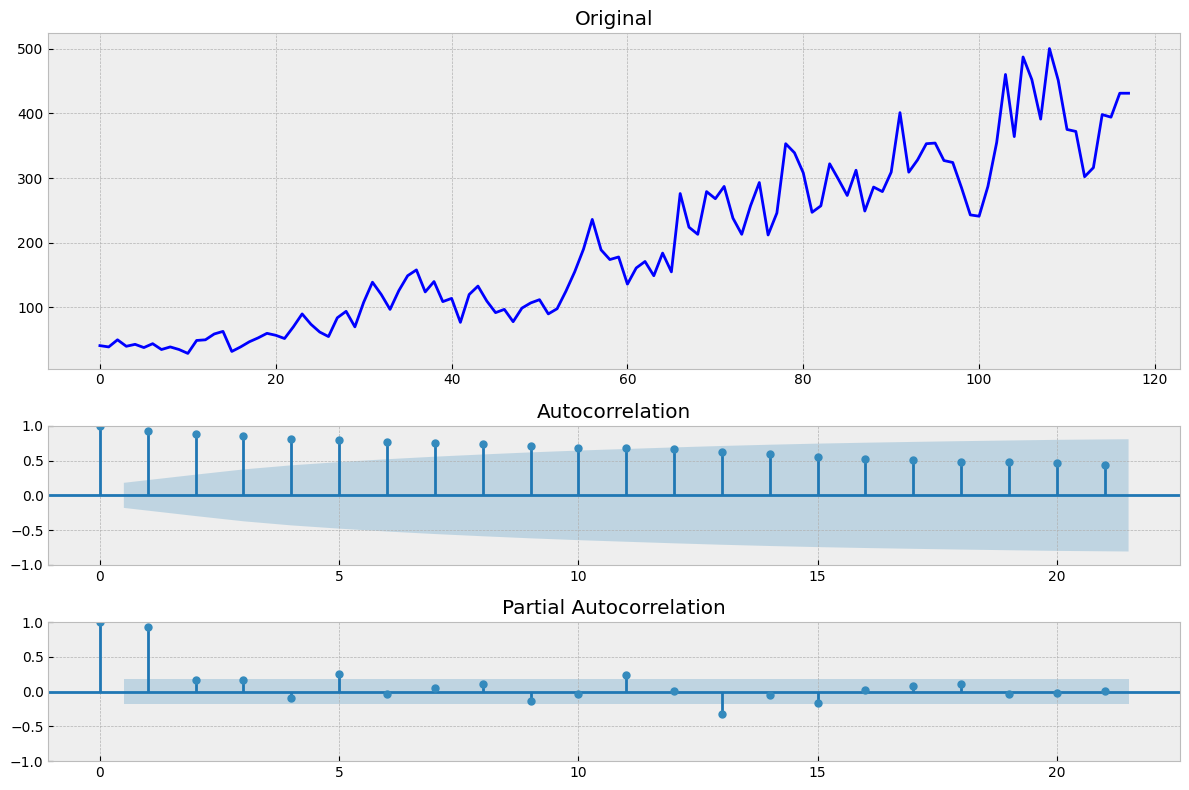

In [53]:
tsplot(boston_rob)

Временной ряд нестационарный. Есть явный тренд. Попробуем применить логарифмическое преобразование скользящего среднего.  

In [54]:
boston_rob

0       41
1       39
2       50
3       40
4       43
      ... 
113    316
114    398
115    394
116    431
117    431
Name: Count, Length: 118, dtype: int64

In [57]:
logged_transform = boston_rob.apply(lambda x : np.log(x))
diff = logged_transform - logged_transform.shift(1)

Results of Dickey-Fuller Test:
ADF Statistic: -7.601792
p-value: 0.000000
Lags Used: 3.000000
Number of Observations Used: 113.000000
Critical Values:
	1%: -3.490
	5%: -2.887
	10%: -2.581


/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


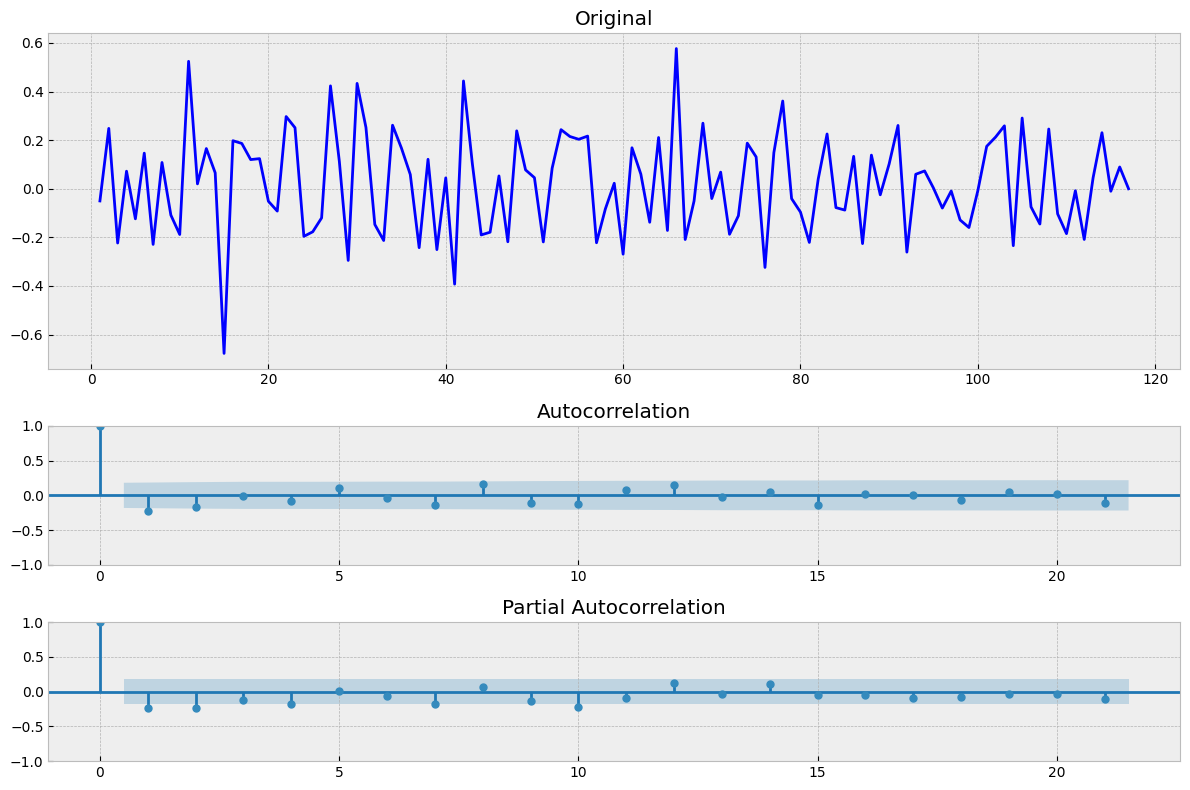

In [58]:
tsplot(diff.dropna())

### monthly-sales-of-company-x-jan-6

Results of Dickey-Fuller Test:
ADF Statistic: 0.654715
p-value: 0.988889
Lags Used: 12.000000
Number of Observations Used: 64.000000
Critical Values:
	1%: -3.537
	5%: -2.908
	10%: -2.591


/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


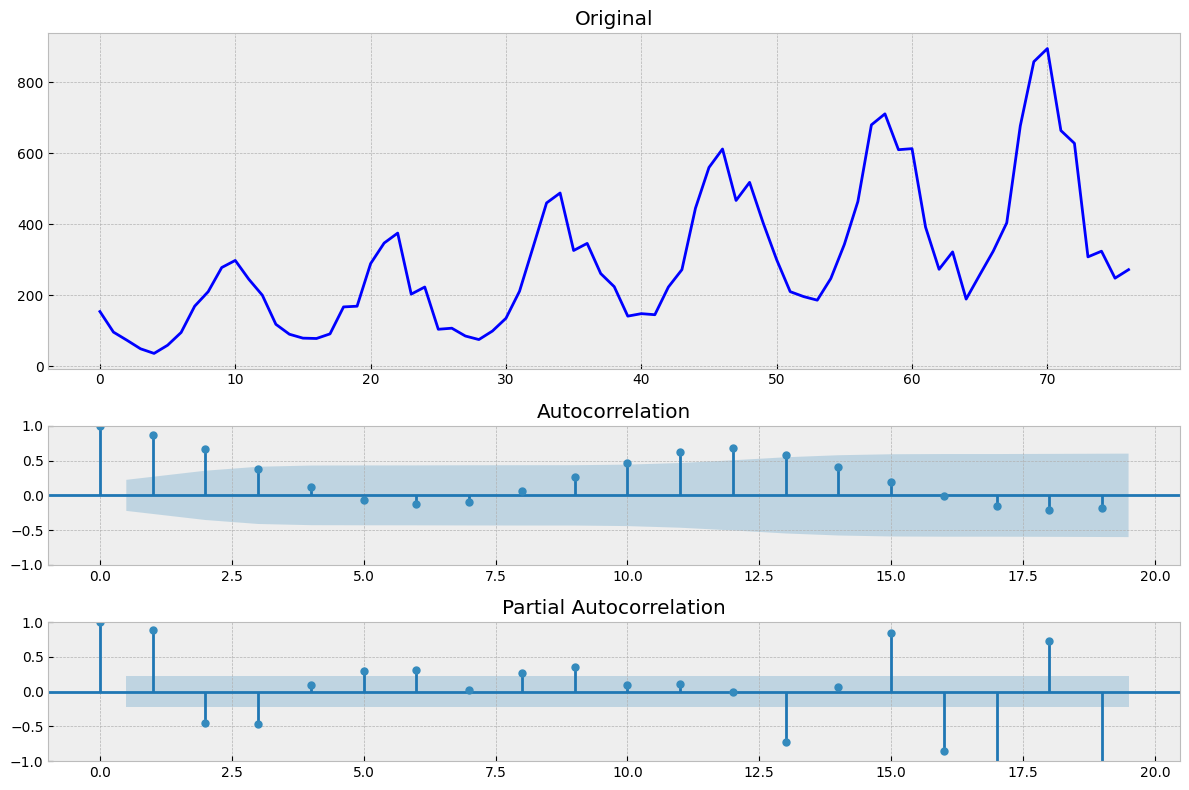

In [59]:
tsplot(sales_of_company_x)

Наблюдается и тренд, и сезонность.

In [69]:
sales_of_company_x_dif = boxcox(sales_of_company_x, 0)
sales_of_company_x_diff = pd.Series(sales_of_company_x_diff)
test_stationarity(sales_of_company_x_diff)

Results of Dickey-Fuller Test:
ADF Statistic: -0.908049
p-value: 0.785310
Lags Used: 12.000000
Number of Observations Used: 64.000000
Critical Values:
	1%: -3.537
	5%: -2.908
	10%: -2.591


In [70]:
sales_of_company_x_diff = np.diff(sales_of_company_x_diff, 1)
sales_of_company_x_diff = pd.Series(sales_of_company_x_diff)
test_stationarity(sales_of_company_x_diff)

Results of Dickey-Fuller Test:
ADF Statistic: -3.135644
p-value: 0.024025
Lags Used: 11.000000
Number of Observations Used: 64.000000
Critical Values:
	1%: -3.537
	5%: -2.908
	10%: -2.591


Стационарности удалось добиться лишь через boxcox и дифференцирование

### weekly-closings-of-the-dowjones

Results of Dickey-Fuller Test:
ADF Statistic: -1.314625
p-value: 0.622455
Lags Used: 0.000000
Number of Observations Used: 161.000000
Critical Values:
	1%: -3.472
	5%: -2.880
	10%: -2.576


/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


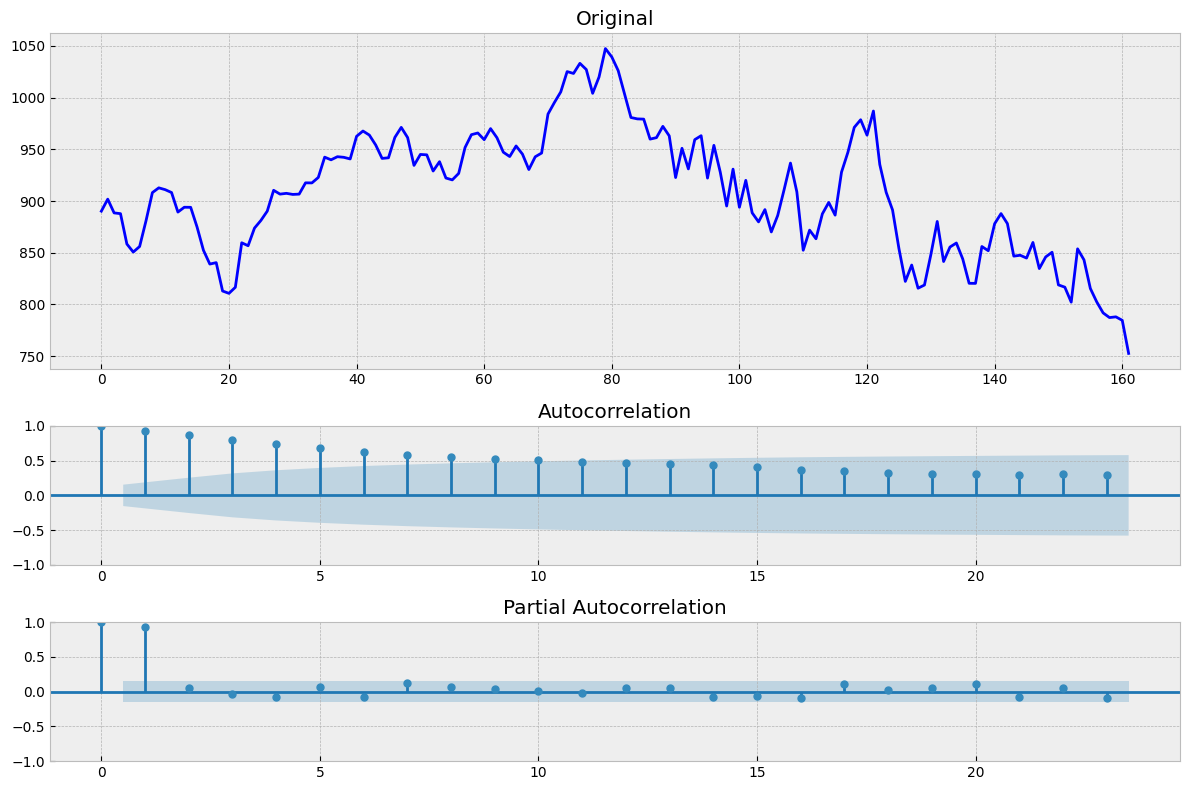

In [71]:
tsplot(dowjones_closings)

In [72]:
dowjones_closings_diff = np.diff(dowjones_closings, 1)
dowjones_closings_diff = pd.Series(dowjones_closings_diff)
test_stationarity(dowjones_closings_diff)

Results of Dickey-Fuller Test:
ADF Statistic: -13.025208
p-value: 0.000000
Lags Used: 0.000000
Number of Observations Used: 160.000000
Critical Values:
	1%: -3.472
	5%: -2.880
	10%: -2.576
